In [2]:
import pandas as pd
% matplotlib inline
import requests
import tweepy
from tweepy import OAuthHandler
import json
import numpy as np
from timeit import default_timer as timer

# Gathering

In [3]:
# Read twitter-archive-enhanced.csv into a dataframe.
twitter_archive_original = pd.read_csv("twitter-archive-enhanced.csv")

In [4]:
# Download image predictions file from URL.
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
f = open("image_predictions.tsv", "w")
f.write(r.text)
f.close()
image_predictions_original = pd.read_csv("image_predictions.tsv", sep = '\t')

In [4]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor

# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive_original.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
# This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

twitter_stats_original = pd.read_json("tweet_json.txt", lines=True)
twitter_stats = twitter_stats_original.drop(twitter_stats_original.columns.difference(['id','retweet_count','favorite_count']), 1)

In [5]:
# Making copies from the original datasets
image_predictions = image_predictions_original
twitter_archive = twitter_archive_original

# Assessing

### Quality Issues
#### General
* Completeness: the number of entries in the three dataframes `image_predictions`, `twitter_archive`, and `twitter_stats` isn't the same.

#### `twitter_archive` table
* The `timestamp` column has wrong dtype (`object`). It should be (`datetime`).
* Some ratings are extracted incorrectly (for example 5/10 istead of 13.5/10).
* Sometimes the wrong value is extracted as a rating (for example dates like 9/11).
* Some ratings are for groups of dogs rather than one dog. Those have a denominator that is 10x the number of dogs.
* Some rows contain retweets and replies, which we aren't interested in as they aren't dog ratings.
* Some rows contain empty values in the `expanded_urls` column.
* The `expanded_url` column sometimes contains more than one url.
* Some rows contain invalid values (links that aren't twitter photos) in the `expanded_urls` column.
* Some rows contain invalid values for the `name` column (such as 'a', 'by', and 'the').

#### `image_predictions` table
* The `p1`, `p2`, and `p3` columns have wrong dtype (`object`). They should be of dtype (`category`).

### Tidiness Issues
* Data for dogs and tweets should be divided into seperate dataframes.

#### `twitter_archive` table
* The `doggo`, `floofer`, `pupper`, and `puppo` columns are values rather than variables.

#### `image_predictions` table
* `p1`, `p2`, and `p3` are the same variable present in three different columns. The same goes for `p1_conf`, `p2_conf`, and `p3_conf` as well as `p1_dog`, `p2_dog`, and `p3_dog`.


In [6]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [7]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [8]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [9]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
twitter_archive[twitter_archive.name.str.len() < 4]['name'].value_counts().head()

a      55
Bo      9
the     8
an      7
Jax     6
Name: name, dtype: int64

In [11]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
twitter_archive[twitter_archive.expanded_urls.isnull()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [13]:
twitter_stats.sample(8)

,favorite_count,id,retweet_count
2220,936,668466899341221888,560
1055,5661,742150209887731712,1783
937,41080,753039830821511168,24013
1207,4257,715696743237730304,1454
2311,244,666739327293083650,71
1376,3080,701570477911896070,1055
1611,3676,685315239903100929,1234
1187,2115,718246886998687744,565


In [14]:
twitter_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
id                2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [15]:
twitter_stats[['favorite_count','retweet_count']].describe()

,favorite_count,retweet_count
count,2354.000000,2354.000000
mean,8080.968564,3164.797366
std,11814.771334,5284.770364
min,0.000000,0.000000
25%,1415.000000,624.500000
50%,3603.500000,1473.500000
75%,10122.250000,3652.000000
max,132810.000000,79515.000000


In [16]:
twitter_archive[twitter_archive['rating_numerator'] < 6].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
605,798576900688019456,NaN,NaN,2016-11-15 17:22:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Not familiar with this breed. N...,6.661041e+17,4.196984e+09,2015-11-16 04:02:55 +0000,https://twitter.com/dog_rates/status/666104133...,1,10,None,None,None,None,None
730,781661882474196992,NaN,NaN,2016-09-30 01:08:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Who keeps sending in pictures without dogs in ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/781661882...,5,10,None,None,None,None,None
765,777885040357281792,NaN,NaN,2016-09-19 15:00:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wesley. He's clearly trespassing. Seem...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/777885040...,3,10,Wesley,None,None,None,None


# Cleaning

## Quality

### Wrong Data Types

#### `image_predictions`: the `p1`, `p2`, and `p3` columns have wrong dtype (`object`). They should be of dtype (`category`).
#### `twitter_archive`: the `timestamp` column has wrong dtype (`object`). It should be (`datetime`).

##### Define
Change the columns dtype to the correct one.

##### Code

In [17]:
image_predictions[['p1','p2','p3']] = image_predictions[['p1','p2','p3']].astype('category')
twitter_archive.timestamp = twitter_archive.timestamp.astype('datetime64')

##### Test

In [18]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null category
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null category
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null category
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), category(3), float64(3), int64(2), object(1)
memory usage: 174.9+ KB


In [19]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

### Invalid Data

#### `twitter_archive`: some ratings are extracted incorrectly (for example 5/10 istead of 13.5/10).
#### `twitter_archive`: sometimes the wrong value is extracted as a rating (for example dates like 9/11).

##### Define
Use regex to re-extract the ratings.

##### Code

In [20]:
# Extract all gruops that match the regex.
matches = twitter_archive.text.str.extractall('(\d+\.?\d?\d?)\/(\d{1,3})').astype('float')
matches.rename(columns = {0:'rating_numerator',1:'rating_denominator'}, inplace = True)
# It's observed that the correct rating is always at the end of the tweet, so we want to use the last match. The maximum number of matches found was 3.
twitter_archive.update(matches.xs(0, level = 'match'))
twitter_archive.update(matches.xs(1, level = 'match'))
twitter_archive.update(matches.xs(2, level = 'match'))
# Drop ratings where denominator is not divisible by 10. Those are not dog ratings.
twitter_archive = twitter_archive[twitter_archive.rating_denominator % 10 == 0]

##### Test

In [21]:
twitter_archive[['text','rating_numerator', 'rating_denominator']][twitter_archive['rating_numerator'] == 13.5]

,text,rating_numerator,rating_denominator
45,This is Bella. She hopes her smile made you sm...,13.5,10.0


In [22]:
twitter_archive[['text','rating_numerator', 'rating_denominator']][twitter_archive['rating_denominator'] != 10]

,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the flo...,84.0,70.0
902,Why does this never happen at my front door......,165.0,150.0
1120,Say hello to this unbelievably well behaved sq...,204.0,170.0
1228,Happy Saturday here's 9 puppers on a bench. 99...,99.0,90.0
1254,Here's a brigade of puppers. All look very pre...,80.0,80.0
1274,"From left to right:\nCletus, Jerome, Alejandro...",45.0,50.0
1351,Here is a whole flock of puppers. 60/50 I'll ...,60.0,50.0
1433,Happy Wednesday here's a bucket of pups. 44/40...,44.0,40.0
1598,Yes I do realize a rating of 4/20 would've bee...,4.0,20.0
1634,"Two sneaky puppers were not initially seen, mo...",143.0,130.0


#### `twitter_archive`: some ratings are for groups of dogs rather than one dog. Those have a denominator that is 10x the number of dogs.

##### Define
Normalize all ratings to be out of 10 and set all denominators to 10.

##### Code

In [23]:
twitter_archive.loc[:,'rating_numerator'] = twitter_archive.rating_numerator / twitter_archive.rating_denominator * 10
twitter_archive.loc[:,'rating_denominator'] = 10

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


##### Test

In [24]:
twitter_archive.rating_numerator.describe()

count    2353.000000
mean       12.150034
std        40.806426
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [25]:
twitter_archive.rating_denominator.describe()

count    2353.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
Name: rating_denominator, dtype: float64

#### `twitter_archive`: some rows contain retweets and replies, which we aren't interested in as they aren't dog ratings.

##### Define
Remove the non-NaN values from columns `retweeted_status_id` and `in_reply_to_status_id`.

##### Code

In [26]:
twitter_archive=twitter_archive[~twitter_archive['retweeted_status_id'].notna()]
twitter_archive=twitter_archive[~twitter_archive['in_reply_to_status_id'].notna()]

##### Test

In [27]:
sum(twitter_archive.retweeted_status_timestamp.notna())

0

In [28]:
sum(twitter_archive.retweeted_status_user_id.notna())

0

In [29]:
sum(twitter_archive.retweeted_status_id.notna())

0

In [30]:
sum(twitter_archive.in_reply_to_status_id.notna())

0

In [31]:
sum(twitter_archive.in_reply_to_user_id.notna())

0

In [32]:
# Now let's drop those columns
twitter_archive = twitter_archive.drop(['retweeted_status_timestamp','retweeted_status_user_id','retweeted_status_id','in_reply_to_user_id','in_reply_to_status_id'],axis = 1)

#### `twitter_archive`: some rows contain empty values in the `expanded_urls` column.

##### Define
Drop rows with NaN in `expanded_urls` column.

##### Code

In [33]:
twitter_archive = twitter_archive[twitter_archive.expanded_urls.notna()]

##### Test

In [34]:
sum(twitter_archive.expanded_urls.isna())

0

#### The `expanded_url` column sometimes contains more than one url.

##### Define
Split the column content by `,` then expand into multiple rows.

##### Code

In [35]:
# Split row content by (,) and concatenate the new row into the intermediate table 'url_table'.
url_table = pd.concat([pd.Series(row['tweet_id'], row['expanded_urls'].split(',')) for _, row in twitter_archive.iterrows()]).reset_index()
# Drop the 'expanded_urls' column then merge the expanded column from 'url_table'.
twitter_archive.drop('expanded_urls', axis = 1, inplace = True)
url_table.rename(columns = {0: "tweet_id", "index": "expanded_urls"}, inplace = True)
twitter_archive = twitter_archive.merge(url_table, on = 'tweet_id')

##### Test

In [36]:
twitter_archive.expanded_urls.head()

0    https://twitter.com/dog_rates/status/892420643...
1    https://twitter.com/dog_rates/status/892177421...
2    https://twitter.com/dog_rates/status/891815181...
3    https://twitter.com/dog_rates/status/891689557...
4    https://twitter.com/dog_rates/status/891327558...
Name: expanded_urls, dtype: object

In [37]:
len(twitter_archive[twitter_archive.expanded_urls.str.contains(',',regex=False)])

0

#### `twitter_archive`: some rows contain invalid values (links that aren't twitter photos) in the `expanded_urls` column.

##### Define
Drop the rows which don't contain `/photo/` in `expanded_urls`.

##### Code

In [38]:
# Valid twitter links for photos always contain '/photo/', so we drop everything else.
twitter_archive = twitter_archive[twitter_archive['expanded_urls'].str.contains('/photo/', na = '') == True]

##### Test

In [39]:
twitter_archive['expanded_urls'].str.contains('/photo/').sum()

2719

In [40]:
len(twitter_archive)

2719

#### `twitter_archive`: some rows contain invalid values for the `name` column (such as 'a', 'by', and 'the').

##### Define
* We noticed that all valid dog names begin with capital letters, so we replace the names that begins with small letters with `np.NaN`.
* We replace `None` with `np.NaN`.
* Manually replace `O` with `O'Malley`.

##### Code

In [41]:
twitter_archive['name'][twitter_archive.name.str.slice(stop=1).str.islower()] = np.NaN
twitter_archive['name'].replace('None',np.NaN,inplace = True)
twitter_archive.loc[twitter_archive.text.str.contains('O\'Malley'),'name'] = 'O\'Malley'

##### Test

In [42]:
pd.options.display.max_rows = 999
twitter_archive.name.value_counts()

Cooper            18
Charlie           18
Oliver            15
Tucker            14
Bo                13
Penny             13
Lola              13
Bella             13
Koda              13
Louis             12
Toby              11
Bailey            11
Lucy              11
Stanley           10
Oscar              9
Leo                9
Bentley            9
Sunny              9
Winston            9
Daisy              9
Winnie             9
Cassie             8
Chester            8
Scout              8
Riley              8
Zeke               8
Finn               8
Sadie              8
Brody              8
Milo               7
Frankie            7
Calvin             7
Odie               7
Paisley            7
Mister             7
Buddy              7
Bear               7
Atlas              7
Dave               7
George             6
Dexter             6
Olive              6
Gary               6
Phil               6
Archie             6
Jax                6
Samson             6
Gizmo        

In [43]:
pd.reset_option('display.max_rows')

## Tidiness

#### `twitter_archive`: the `doggo`, `floofer`, `pupper`, and `puppo` columns are values rather than variables.

##### Define
It's observed that some rows have `None` in all four columns while others have one or more columns which aren't `None`. 
Using `melt()` directly to transform the four columns into rows would leave us unable to correctly identify and drop duplicates. That's why we first assign a temporary rank of `doge` to rows who don't have a rank.

##### Code

In [44]:
# Assign temporary rank to rows which don't have any.
twitter_archive.loc[(twitter_archive.doggo == 'None') & (twitter_archive.floofer == 'None') & (twitter_archive.pupper == 'None') & (twitter_archive.puppo == 'None'),'doggo']='doge'
# Melt the unwanted columns.
twitter_archive = pd.melt(twitter_archive,id_vars = ['tweet_id','timestamp','source','text','expanded_urls','rating_numerator','rating_denominator','name'], value_name = 'dog_rank')
# Drop unneeded 'variable' column.
twitter_archive.drop('variable',axis=1,inplace = True)
# Drop duplicates.
twitter_archive = twitter_archive[twitter_archive.dog_rank != 'None']
# Get rid of temporary assigned rank.
twitter_archive.dog_rank.replace('doge','None',inplace = True)

##### Test

In [45]:
twitter_archive.dog_rank.value_counts()

None       2271
pupper      290
doggo       119
puppo        40
floofer      12
Name: dog_rank, dtype: int64

#### `image_predictions`: `p1`, `p2`, and `p3` are the same variable present in three different columns. 
#### The same goes for `p1_conf`, `p2_conf`, and `p3_conf` as well as `p1_dog`, `p2_dog`, and `p3_dog`.

##### Define
Make temporary dataframes for each prediction then concatenate into one big dataframe.

##### Code

In [46]:
image_predictions_1 = image_predictions[['tweet_id','jpg_url','img_num','p1','p1_conf','p1_dog']]
image_predictions_1 = image_predictions_1.rename(columns = {'p1':'prediction','p1_conf':'confidence','p1_dog':'is_dog_breed'})
image_predictions_1['prediction_number'] = 1

In [47]:
image_predictions_2 = image_predictions[['tweet_id','jpg_url','img_num','p2','p2_conf','p2_dog']]
image_predictions_2 = image_predictions_2.rename(columns = {'p2':'prediction','p2_conf':'confidence','p2_dog':'is_dog_breed'})
image_predictions_2['prediction_number'] = 2

In [48]:
image_predictions_3 = image_predictions[['tweet_id','jpg_url','img_num','p3','p3_conf','p3_dog']]
image_predictions_3 = image_predictions_3.rename(columns = {'p3':'prediction','p3_conf':'confidence','p3_dog':'is_dog_breed'})
image_predictions_3['prediction_number'] = 3

In [49]:
image_predictions = pd.concat([image_predictions_1, image_predictions_2, image_predictions_3])

##### Test

In [50]:
image_predictions.head()

,tweet_id,jpg_url,img_num,prediction,confidence,is_dog_breed,prediction_number
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,1
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,1
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,1
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,1
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,1


#### Data for dogs and tweets should be divided into seperate dataframes.

##### Define
* Merge `twitter_stats` dataframe onto `twitter_archive`.
* Make a new dataframe `dog_table` by merging relevant columns from `twitter_archive` onto `image_predictions`.

##### Code

In [51]:
twitter_stats.rename(columns = {'id': 'tweet_id'}, inplace = True)
twitter_archive = twitter_archive.merge(twitter_stats, on = 'tweet_id')
dog_table = image_predictions.merge(twitter_archive[['tweet_id', 'rating_numerator', 'rating_denominator', 'name','dog_rank']], on = 'tweet_id')
twitter_archive.drop(['rating_numerator', 'rating_denominator', 'name', 'dog_rank'], axis = 1, inplace = True)

##### Test

In [52]:
twitter_archive.head()

,tweet_id,timestamp,source,text,expanded_urls,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,39467,8853
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,33819,6514
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,25461,4328
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,42908,8964
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,41048,9774


In [53]:
dog_table.head()

,tweet_id,jpg_url,img_num,prediction,confidence,is_dog_breed,prediction_number,rating_numerator,rating_denominator,name,dog_rank
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,1,8.0,10,NaN,None
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,collie,0.156665,True,2,8.0,10,NaN,None
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Shetland_sheepdog,0.061428,True,3,8.0,10,NaN,None
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,1,7.0,10,NaN,None
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,miniature_pinscher,0.074192,True,2,7.0,10,NaN,None


# Storing

In [54]:
twitter_archive.to_csv('twitter_archive_master.csv')
dog_table.to_csv('dog_table_master.csv')

# Analyzing

### Insight 1: Which is the most favorited dog breed in the dataset, on average?

In [55]:
highest_prediction = dog_table.query('prediction_number == 1')
twitter_archive_merged = twitter_archive.merge(highest_prediction, on = 'tweet_id')
dog_breed_likes = twitter_archive_merged[['favorite_count','prediction','is_dog_breed']]
dog_breed_likes = dog_breed_likes[dog_breed_likes.is_dog_breed == True]
dog_breed_likes = dog_breed_likes.drop_duplicates()
dog_breed_likes['freq'] = dog_breed_likes.groupby(by = 'prediction')['prediction'].transform('count')
dog_breed_likes['favorite_count_norm'] = dog_breed_likes['favorite_count'] / dog_breed_likes['freq']
breed_likes_agg = pd.DataFrame() 
breed_likes_agg['breeds'] = dog_breed_likes.prediction.unique()
for breed in breed_likes_agg['breeds']:
    breed_likes_agg.loc[breed_likes_agg.breeds == breed,'likes'] = dog_breed_likes.loc[dog_breed_likes.prediction == breed,'favorite_count_norm'].sum()
breed_likes_agg.sort_values('likes',ascending = False).head()

,breeds,likes
21,Saluki,24060.0
8,French_bulldog,17913.0
78,Afghan_hound,17337.5
48,giant_schnauzer,17314.5
109,black-and-tan_coonhound,17012.0


#### The most favorited dog breed is the Saluki with 24060 favorites on average per appearance.

### Insight 2: Which tweet length gets the most retweets?

In [56]:
tweet_length = twitter_archive[['tweet_id', 'retweet_count']]
tweet_length['length'] = twitter_archive.text.str.len()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
tweet_length.describe()

,tweet_id,retweet_count,length
count,2.732000e+03,2732.000000,2732.000000
mean,7.469501e+17,3041.455344,123.326867
std,6.825051e+16,4045.790538,25.918436
min,6.660209e+17,16.000000,36.000000
25%,6.812934e+17,786.750000,106.000000
50%,7.351965e+17,1762.000000,132.000000
75%,8.033026e+17,3727.000000,140.000000
max,8.924206e+17,48265.000000,167.000000


In [58]:
average_retweets = pd.DataFrame()
average_retweets['tweet_length_min'] = pd.Series([tweet_length.length.min(),tweet_length.length.quantile(0.25),tweet_length.length.quantile(0.50),tweet_length.length.quantile(0.75)])
average_retweets['tweet_length_max'] = pd.Series([tweet_length.length.quantile(0.25),tweet_length.length.quantile(0.50),tweet_length.length.quantile(0.75),tweet_length.length.max()])
average_retweets.loc[average_retweets.tweet_length_max == 106.0, 'retweet_count'] = tweet_length.query('length >= 36 and length <= 106').retweet_count.sum()
average_retweets.loc[average_retweets.tweet_length_max == 132.0, 'retweet_count'] = tweet_length.query('length > 106 and length <= 132').retweet_count.sum()
average_retweets.loc[average_retweets.tweet_length_max == 140.0, 'retweet_count'] = tweet_length.query('length > 132 and length <= 140').retweet_count.sum()
average_retweets.loc[average_retweets.tweet_length_max == 167.0, 'retweet_count'] = tweet_length.query('length > 140 and length <= 167').retweet_count.sum()
average_retweets.sort_values('retweet_count',ascending=False)

,tweet_length_min,tweet_length_max,retweet_count
1,106.0,132.0,2460898.0
3,140.0,167.0,2281544.0
2,132.0,140.0,1857760.0
0,36.0,106.0,1709054.0


#### The most retweeted tweets have a length that lies between 106 and 132 characters.

### Insight 3: Which dog rank has the highest rating, on average?

In [59]:
temp_df = dog_table[['tweet_id','dog_rank','rating_numerator']].drop_duplicates()
rank_ratings = temp_df.dog_rank.value_counts(dropna=False).rename_axis('dog_rank').reset_index(name='freq')
rank_ratings.loc[rank_ratings.dog_rank == "floofer", 'rating_sum'] = temp_df.query('dog_rank == "floofer"').rating_numerator.sum()
rank_ratings.loc[rank_ratings.dog_rank == "pupper", 'rating_sum'] = temp_df.query('dog_rank == "pupper"').rating_numerator.sum()
rank_ratings.loc[rank_ratings.dog_rank == "doggo", 'rating_sum'] = temp_df.query('dog_rank == "doggo"').rating_numerator.sum()
rank_ratings.loc[rank_ratings.dog_rank == "puppo", 'rating_sum'] = temp_df.query('dog_rank == "puppo"').rating_numerator.sum()
rank_ratings.loc[rank_ratings.dog_rank == 'None', 'rating_sum'] = temp_df.query('dog_rank == "None"').rating_numerator.sum()
rank_ratings['average_rating'] = rank_ratings['rating_sum'] / rank_ratings['freq']
rank_ratings.sort_values('average_rating', ascending = False)

,dog_rank,freq,rating_sum,average_rating
3,puppo,23,277.00,12.043478
4,floofer,7,83.00,11.857143
0,None,1614,18940.51,11.735136
2,doggo,64,751.00,11.734375
1,pupper,199,2105.27,10.579246


#### Puppo gets the highest rating, on average.

# Visualizing

### Dog Breed Composition

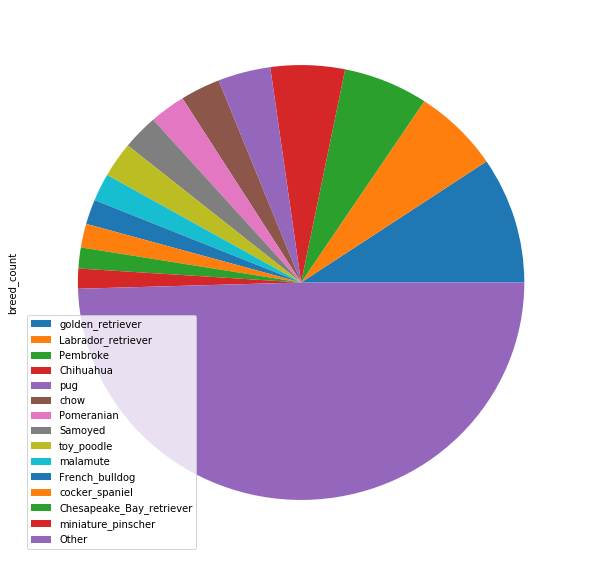

In [60]:
num_to_plot = 13
breeds_table = dog_table.query('prediction_number == 1')
breeds_table = breeds_table[['tweet_id','prediction','is_dog_breed']]
breeds_table = breeds_table[breeds_table.is_dog_breed == True].drop_duplicates()
breeds_counts = breeds_table.prediction.value_counts().rename_axis('dog_breed').reset_index(name='breed_count')
new_row = {'dog_breed':'Other','breed_count':breeds_counts.query('index > @num_to_plot').breed_count.sum()}
breeds_counts = breeds_counts.query('index <= @num_to_plot')
breeds_counts = breeds_counts.append(new_row, ignore_index=True)
breeds_counts = breeds_counts.set_index('dog_breed')
breeds_counts.plot(y = 'breed_count',labels = None,kind='pie',figsize = (10, 10))

#### The plot shows that the Golden Retriver appears the highest number of times, followed by the Labrador Retriever, and then the Pembroke.